# Video Game Sales Prediction

## Part 0: Introduction

This dataset, inspired by Gregory Smith's web scrape of VGChartz, extends video game sales data with additional variables sourced from Metacritic. It includes information on game sales by region, critic and user scores, and game metadata such as platform, genre, and ESRB ratings. 

### Objective: To create a classification model that can predict the global sale of a video game (Note the target column in the dataset is Global_Sales)

We will follow the following steps:
1. Read the Data
2. Reduce the data by
   - Removing N/A values
   - Removing Outliers
3. Data Exploration
   - Looking into the different types of games (consoles, PCs, etc..)
4. Feature Engineering
   - One Hot encoding categorical variables
5. Modeling
   - K Nearest Neighbor
   - Logistic Regression
   - Random Forest
   - Decision Tree


# Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Reading and Understanding the DataSet

In [12]:
file_path = "Video_Games_Sales_as_at_22_Dec_2016.csv"
df = pd.read_csv(file_path)

df.shape

(16719, 16)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


## Features

1. **Name**: The title of the video game *(Nominal)* – serves as an identifier for each game.

2. **Platform**: The gaming console or platform for which the game was released *(Nominal)* – e.g., PS4, Xbox, PC.

3. **Year_of_Release**: The year when the game was released *(Discrete)* – Although recorded as whole numbers, this variable represents a time series trend.

4. **Genre**: The category or type of the game *(Nominal)* – e.g., Action, Adventure, Sports.

5. **Publisher**: The company responsible for publishing and distributing the game *(Nominal)* – e.g., Nintendo, EA Sports.

6. **NA_Sales**: Total sales in millions of units in North America *(Continuous)* – Indicates the success of the game in the North American market.

7. **EU_Sales**: Total sales in millions of units in Europe *(Continuous)* – Measures the game’s performance in the European market.

8. **JP_Sales**: Total sales in millions of units in Japan *(Continuous)* – Highlights sales in one of the major gaming markets globally.

9. **Other_Sales**: Total sales in millions of units in regions other than North America, Europe, and Japan *(Continuous)*.

10. **Global_Sales**: Total worldwide sales in millions of units *(Continuous)* – The cumulative success of the game globally. **Target Variable**.

11. **Critic_Score**: Aggregate critic review score, typically out of 100 *(Continuous)* – Reflects the reception of the game by professional critics.

12. **Critic_Count**: The number of critics who reviewed the game *(Discrete)* – Provides insight into the reliability of the `Critic_Score`.

13. **User_Score**: The average user rating of the game, typically on a 0–10 scale *(Continuous)* – Reflects public reception of the game.

14. **User_Count**: The number of users who rated the game *(Discrete)* – Indicates how engaged the audience was.

15. **Developer**: The company or team that created the game *(Nominal)* – Provides insights into the production and quality of the game.

16. **Rating**: The ESRB rating assigned to the game *(Nominal)* – Indicates the age group for which the game is suitable, e.g., E (Everyone), T (Teen), M (Mature).

# Data Preprocessing

In [16]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64


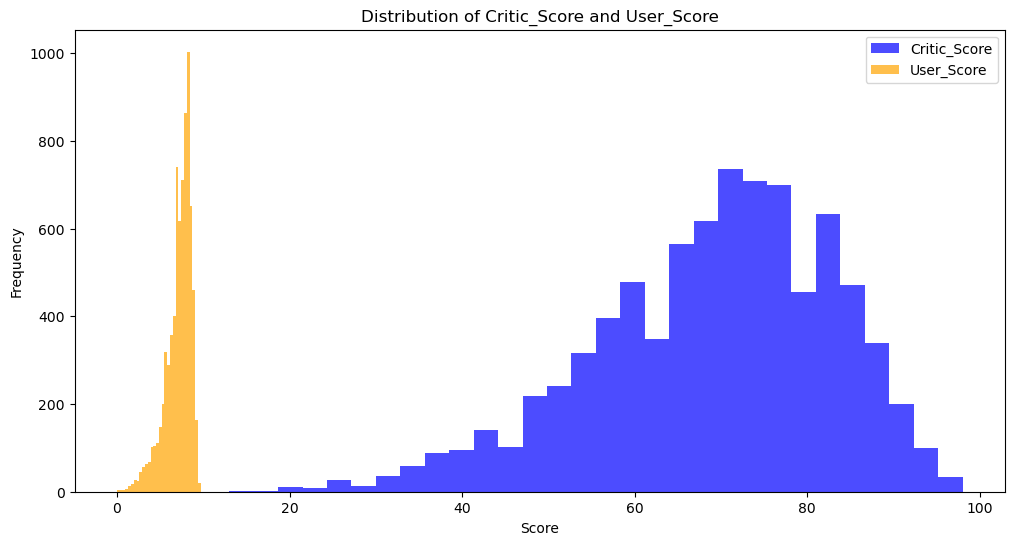

In [17]:
# Visualize the distribution of Critic_Score and User_Score to decide how to fill in the missing values
plt.figure(figsize=(12, 6))
plt.hist(
    df["Critic_Score"].dropna(), bins=30, color="blue", alpha=0.7, label="Critic_Score"
)
plt.hist(
    pd.to_numeric(df["User_Score"], errors="coerce").dropna(),
    bins=30,
    color="orange",
    alpha=0.7,
    label="User_Score",
)
plt.title("Distribution of Critic_Score and User_Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Based on the distribution of data, using the median would be a good choice. 

In [19]:
# Impute missing `Critic_Score` and `User_Score` with the median
df["Critic_Score"] = df["Critic_Score"].fillna(df["Critic_Score"].median())
df["User_Score"] = pd.to_numeric(
    df["User_Score"], errors="coerce"
)  # Convert "tbd" to NaN
df["User_Score"] = df["User_Score"].fillna(df["User_Score"].median())

# Handle categorical `Rating` by filling with the mode
df["Rating"] = df["Rating"].fillna(df["Rating"].mode()[0])

# Verify changes in the dataset
print("\nDataset info after handling missing values and dropping rows:")
df.info()


Dataset info after handling missing values and dropping rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     16719 non-null  float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       16719 non-null  float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           16719 non-null  object 


In [20]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Verify the dataset after dropping rows
print("\nDataset info after removing all rows with any missing values:")
df.info()


Dataset info after removing all rows with any missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6889 non-null   object 
 1   Platform         6889 non-null   object 
 2   Year_of_Release  6889 non-null   float64
 3   Genre            6889 non-null   object 
 4   Publisher        6889 non-null   object 
 5   NA_Sales         6889 non-null   float64
 6   EU_Sales         6889 non-null   float64
 7   JP_Sales         6889 non-null   float64
 8   Other_Sales      6889 non-null   float64
 9   Global_Sales     6889 non-null   float64
 10  Critic_Score     6889 non-null   float64
 11  Critic_Count     6889 non-null   float64
 12  User_Score       6889 non-null   float64
 13  User_Count       6889 non-null   float64
 14  Developer        6889 non-null   object 
 15  Rating           6889 non-null   object 
dtypes

In [21]:
# Count the number of occurrences for each game name
duplicates = df["Name"].value_counts()

# Filter games that appear more than once
games_with_duplicates = duplicates[duplicates > 1]

# View rows for these games
duplicated_rows = df[df["Name"].isin(games_with_duplicates.index)]

# Display the duplicated rows
duplicated_rows

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,97.0,50.0,8.2,3994.0,Rockstar North,M
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81,95.0,80.0,9.0,1588.0,Rockstar North,M
23,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.66,5.14,0.06,1.41,16.27,97.0,58.0,8.1,3711.0,Rockstar North,M
24,Grand Theft Auto: Vice City,PS2,2002.0,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15,95.0,62.0,8.7,730.0,Rockstar North,M
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.04,4.24,0.13,1.32,14.73,88.0,81.0,3.4,8713.0,"Infinity Ward, Sledgehammer Games",M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16618,Legacy of Kain: Defiance,PC,2003.0,Action,Eidos Interactive,0.00,0.01,0.00,0.00,0.01,70.0,11.0,8.7,67.0,Nixxes Software,M
16634,Sébastien Loeb Rally Evo,XOne,2016.0,Racing,Milestone S.r.l,0.00,0.01,0.00,0.00,0.01,63.0,8.0,8.2,22.0,Milestone S.r.l,E
16664,Prison Architect,XOne,2016.0,Action,Introversion Software,0.01,0.00,0.00,0.00,0.01,74.0,13.0,6.7,7.0,"Introversion, Double Eleven",E
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M


In [22]:
import pandas as pd

# Example dataframe
# df = pd.read_csv('your_dataset.csv')

# Define the aggregation rules

# Group by 'Name' and aggregate using the rules
df = (
    df.groupby("Name")
    .agg(
        {
            "Platform": lambda x: (
                "Cross-Platform" if len(x.unique()) > 1 else x.unique()[0]
            ),  # Combine platforms as a string
            "Year_of_Release": "max",  # Use the earliest release year -> should prioritize latest release date because dont want to bring up old data
            "Genre": lambda x: x.mode()[0],  # Use the most frequent genre
            "Publisher": lambda x: x.mode()[0],  # Use the most frequent publisher
            "NA_Sales": "sum",
            "EU_Sales": "sum",
            "JP_Sales": "sum",
            "Other_Sales": "sum",
            "Global_Sales": "sum",
            "Critic_Score": "mean",  # Average critic score
            "Critic_Count": "sum",  # Total critic count
            "User_Score": "mean",  # Average user score
            "User_Count": "sum",  # Total user count
            "Developer": lambda x: x.mode()[0],  # Use the most frequent developer
            "Rating": lambda x: x.mode()[0],  # Use the most frequent rating
        }
    )
    .reset_index()
)

# the top 20 games by global
df.sort_values(by="Global_Sales", ascending=False).head(20)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
4262,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.000000,51.0,8.000000,322.0,Nintendo,E
1511,Grand Theft Auto V,Cross-Platform,2015.0,Action,Take-Two Interactive,23.84,23.42,1.42,7.90,56.57,96.800000,245.0,8.080000,15124.0,Rockstar North,M
2110,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.000000,73.0,8.300000,709.0,Nintendo,E
4264,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.000000,73.0,8.000000,192.0,Nintendo,E
493,Call of Duty: Modern Warfare 3,Cross-Platform,2011.0,Shooter,Activision,15.54,11.15,0.62,3.29,30.59,81.000000,162.0,2.725000,20053.0,"Infinity Ward, Sledgehammer Games",M
2591,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.000000,65.0,8.500000,431.0,Nintendo,E
488,Call of Duty: Black Ops II,Cross-Platform,2012.0,Shooter,Activision,14.08,10.84,0.72,3.76,29.40,80.250000,136.0,5.300000,5041.0,Treyarch,M
487,Call of Duty: Black Ops,Cross-Platform,2010.0,Shooter,Activision,16.99,8.54,0.59,3.08,29.19,82.250000,185.0,6.125000,2689.0,Treyarch,M
4260,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.000000,41.0,6.600000,129.0,Nintendo,E
2594,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.000000,80.0,8.400000,594.0,Nintendo,E


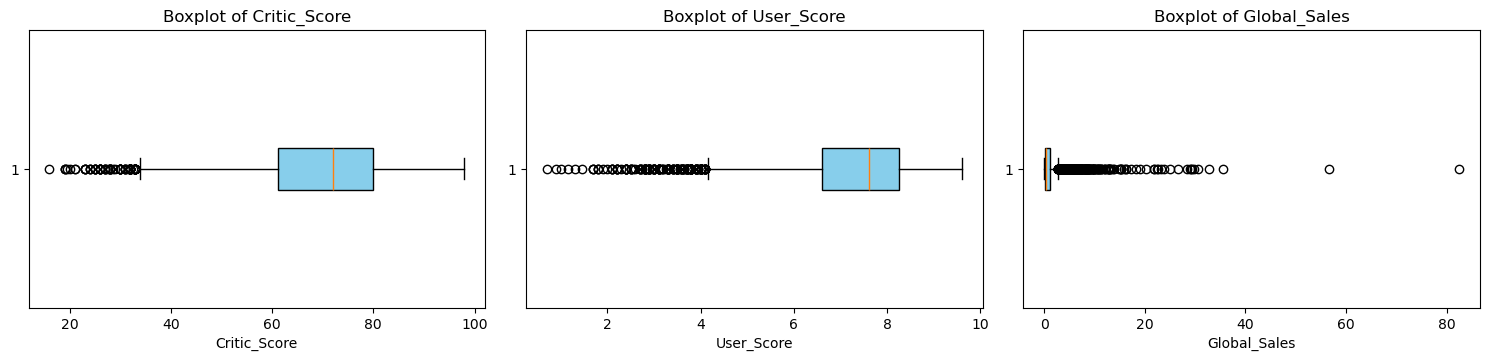

(4426, 16)

In [23]:
# List of numerical columns to check for outliers
numerical_columns = ["Critic_Score", "User_Score", "Global_Sales"]

# Generate boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, start=1):
    if col in df.columns:
        plt.subplot(3, 3, i)  # Create subplots (3 rows x 3 columns for 9 plots)
        plt.boxplot(
            df[col].dropna(),
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"),
        )
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
plt.tight_layout()
plt.show()
df.shape

# Data Exploration 

In [25]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000
mean,2007.078626,0.608800,0.365233,0.099480,0.127716,1.201512,69.558647,44.908043,7.261731,271.519205
std,4.282526,1.434334,1.035689,0.355542,0.388905,2.878167,13.949344,37.179004,1.393321,1012.604229
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,16.000000,4.000000,0.700000,4.000000
25%,2004.000000,0.070000,0.020000,0.000000,0.010000,0.130000,61.270833,18.000000,6.600000,14.000000
50%,2007.000000,0.180000,0.080000,0.000000,0.030000,0.380000,72.000000,34.000000,7.600000,37.000000
75%,2010.000000,0.590000,0.300000,0.050000,0.100000,1.170000,80.000000,60.000000,8.250000,124.000000
max,2016.000000,41.360000,28.960000,6.500000,10.700000,82.530000,98.000000,252.000000,9.600000,24807.000000


Here we are looking at the data at a high level to see statisical characteristics.

- It clearly shows that none of the data is missing columns
- It shows relevant information such as mean, count, and min which can help indentify future information
- It clearly shows these features are numerical but cannot show the categorical features which we will fix later on

## Categorical Data

In [28]:
categorical_columns = ["Platform", "Genre", "Publisher", "Developer", "Rating"]

for col in categorical_columns:
    print(f"Value counts for {col}:\n")
    print(df[col].value_counts())

Value counts for Platform:

Platform
Cross-Platform    1422
PS2                596
DS                 331
PC                 306
Wii                266
PSP                235
X360               188
XB                 183
GBA                175
PS3                153
PS                 132
GC                 115
3DS                113
PS4                 75
PSV                 59
WiiU                43
XOne                22
DC                  12
Name: count, dtype: int64
Value counts for Genre:

Genre
Action          876
Role-Playing    588
Sports          511
Shooter         506
Racing          357
Misc            281
Platform        270
Fighting        260
Simulation      237
Strategy        229
Adventure       204
Puzzle          107
Name: count, dtype: int64
Value counts for Publisher:

Publisher
Electronic Arts                399
Nintendo                       290
Sony Computer Entertainment    282
Ubisoft                        277
Activision                     215
            

Based on the frequency, there are a lot of publishers and developers so we will frequency encode developer and publisher and one hot encode the rest of the categorical comumns

In [30]:
# Frequency encode 'Publisher' and 'Developer'
print(df.columns)

# Create a copy of the original DataFrame to avoid modifying it
encoded_df = df.copy()

# Frequency encode 'Publisher' and 'Developer'
for col in ["Publisher", "Developer"]:
    freq = encoded_df[col].value_counts()  # Get frequency counts
    encoded_df[col + "_Freq"] = encoded_df[col].map(freq)  # Map the counts to a new column

# One-hot encode 'Platform', 'Genre', and 'Rating'
one_hot_encoded_df = pd.get_dummies(encoded_df, columns=["Platform", "Genre", "Rating"], drop_first=False)

# Drop the original 'Publisher' and 'Developer' columns
final_encoded_df = one_hot_encoded_df.drop(columns=["Publisher", "Developer"])

# Save as a separate DataFrame if needed
separate_df = final_encoded_df.copy()

separate_df.head(10)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')


,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_M,Rating_RP,Rating_T
0,Tales of Xillia 2,2012.0,0.20,0.12,0.45,0.07,0.84,71.0,59.0,7.900,...,True,False,False,False,False,False,False,False,False,True
1,.hack//Infection Part 1,2002.0,0.49,0.38,0.26,0.13,1.27,75.0,35.0,8.500,...,True,False,False,False,False,False,False,False,False,True
2,.hack//Mutation Part 2,2002.0,0.23,0.18,0.20,0.06,0.68,76.0,24.0,8.900,...,True,False,False,False,False,False,False,False,False,True
3,.hack//Outbreak Part 3,2002.0,0.14,0.11,0.17,0.04,0.46,70.0,23.0,8.700,...,True,False,False,False,False,False,False,False,False,True
4,007 Racing,2000.0,0.30,0.20,0.00,0.03,0.53,51.0,16.0,4.600,...,False,False,False,False,False,False,False,False,False,True
5,007: Quantum of Solace,2008.0,1.55,1.31,0.04,0.40,3.30,63.5,140.0,6.875,...,False,False,False,False,False,False,False,False,False,True
6,007: The World is not Enough,2000.0,0.51,0.35,0.00,0.06,0.92,61.0,11.0,6.700,...,False,False,False,False,False,False,False,False,False,True
7,1 vs. 100,2008.0,0.08,0.00,0.00,0.01,0.08,38.0,5.0,3.200,...,False,False,False,False,False,True,False,False,False,False
8,100 Classic Books,2008.0,0.12,0.52,0.00,0.02,0.66,70.0,7.0,6.000,...,False,False,False,False,False,True,False,False,False,False
9,15 Days,2009.0,0.00,0.01,0.00,0.00,0.01,63.0,6.0,5.800,...,False,False,False,False,False,True,False,False,False,False


Due to the publisher and developer being categorical data we can encode them in order to analyze them easier. 
We use frequency encoding for publisher and developer since there are many of them which can cause the curse
of dimensionality and we one-hot encode Platform, Genre, and Rating since there arent many categories for 
those features as we can see above.

## Numerical Data

We are using a correlation heatmap to see how well the features in the data compare to our target value of global sales

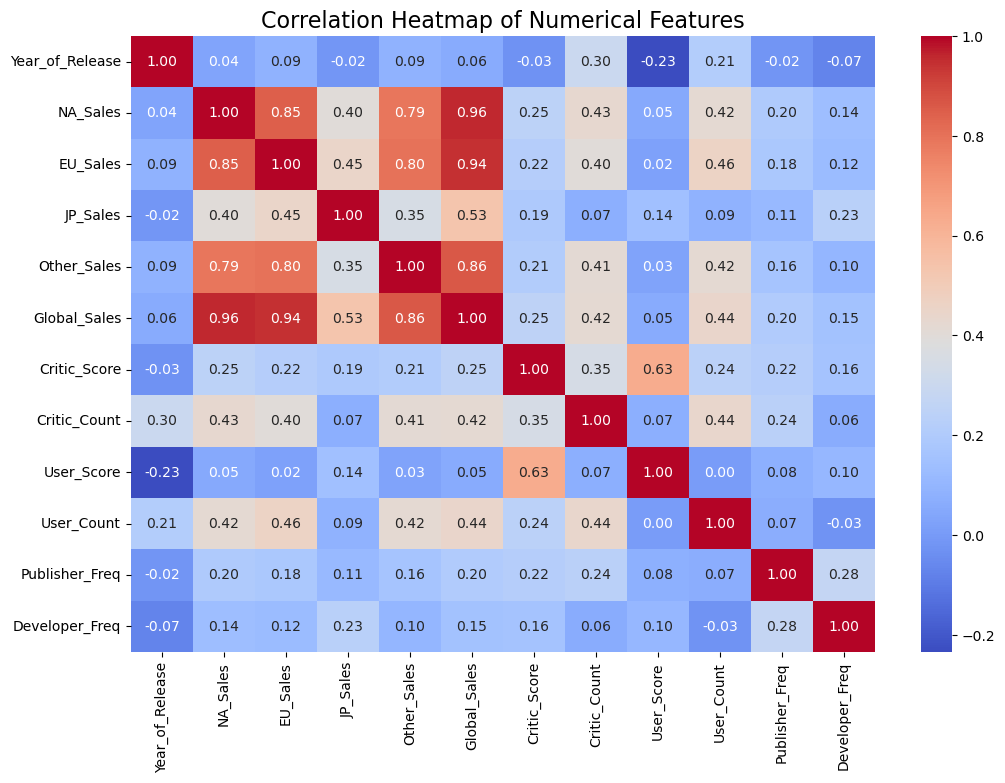

In [34]:
# Select only numerical columns
numerical_data = separate_df.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
cor = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cor,
    xticklabels=cor.columns,
    yticklabels=cor.columns,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

- We can see that year of release has almost no correlation (0.01) to global sales
- Looking at user score and critic score, critic score (0.27) has a higher correlation to global sales than user score (0.10)

# Elaborate more on the target variable

In [36]:
# lower_quartile_critic_count = df["Critic_Count"].describe()["25%"]
# lower_quartile_user_count = df["User_Count"].describe()["25%"]

# df = df[df["Critic_Count"] >= lower_quartile_critic_count]
# df = df[df["User_Count"] >= lower_quartile_user_count]

# print(df.shape)

In [37]:
# print('df["Platform"].unique():', df["Platform"].unique())
# print('df["Genre"].unique():', df["Genre"].unique())
# print('df["Publisher"].unique():', df["Publisher"].unique().__len__())
# print('df["Developer"].unique():', df["Developer"].unique())
# print('df["Rating"].unique():', df["Rating"].unique())

# # df = pd.get_dummies(df, columns=["Platform", "Genre", "Rating"])
# # df.head()
#
# # rating AO - 1
# # rating K-A - 1

## Univariate Analysis 

### Numerical Data 

<Figure size 1800x1000 with 0 Axes>

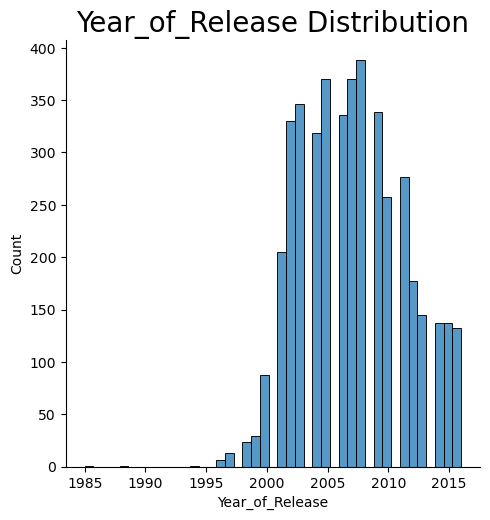

<Figure size 1800x1000 with 0 Axes>

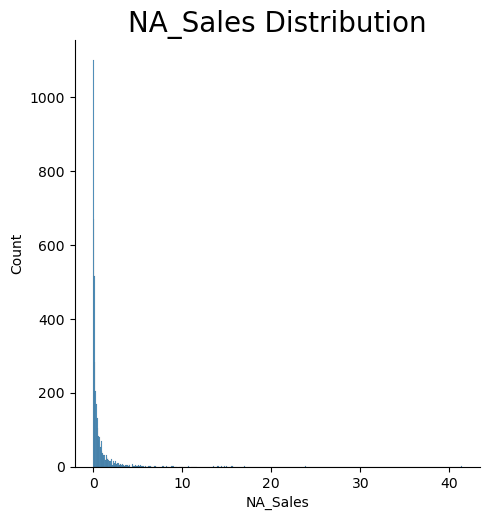

<Figure size 1800x1000 with 0 Axes>

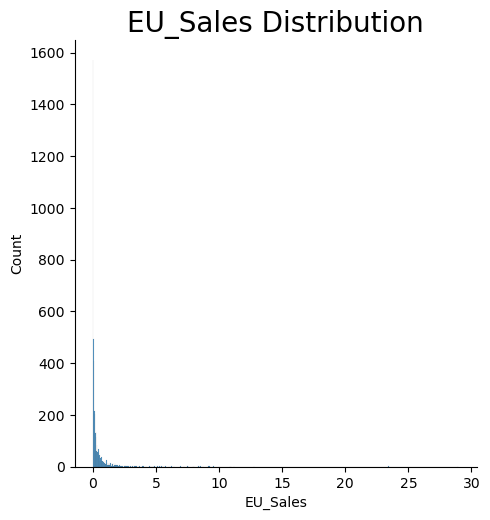

<Figure size 1800x1000 with 0 Axes>

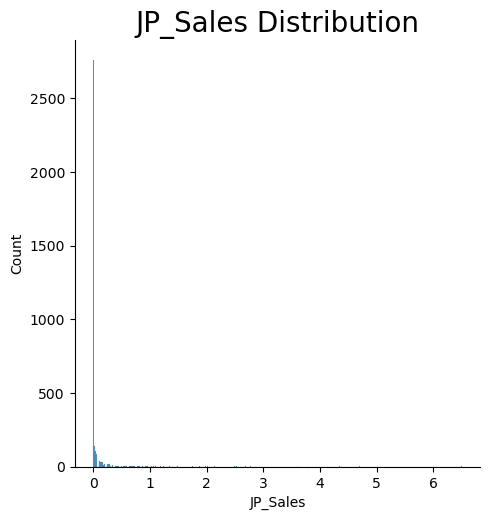

<Figure size 1800x1000 with 0 Axes>

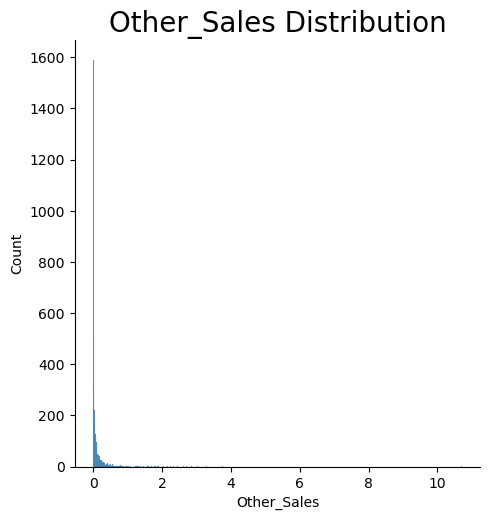

<Figure size 1800x1000 with 0 Axes>

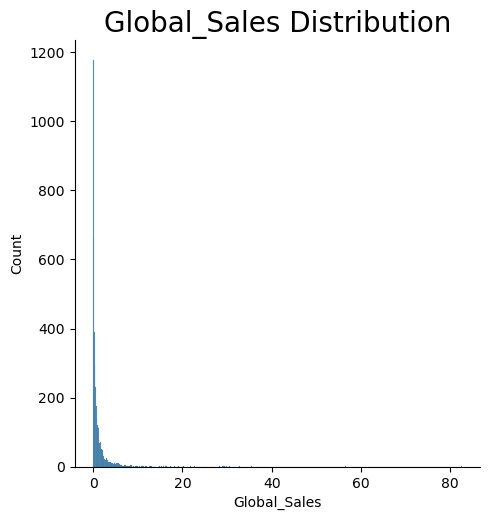

<Figure size 1800x1000 with 0 Axes>

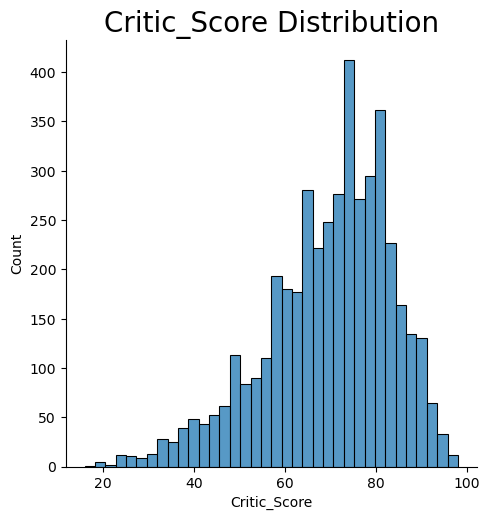

<Figure size 1800x1000 with 0 Axes>

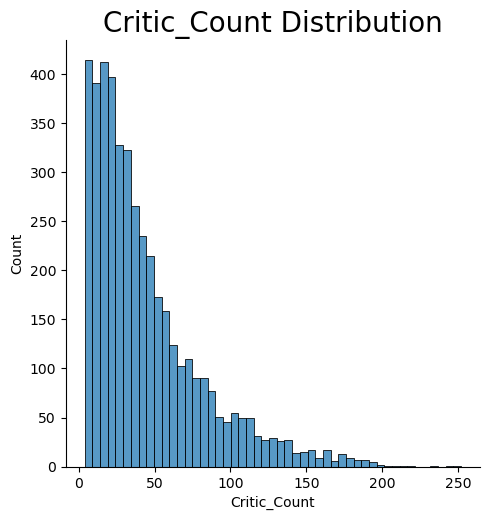

<Figure size 1800x1000 with 0 Axes>

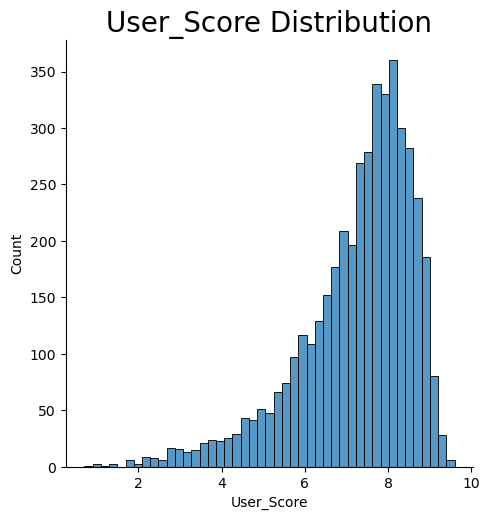

<Figure size 1800x1000 with 0 Axes>

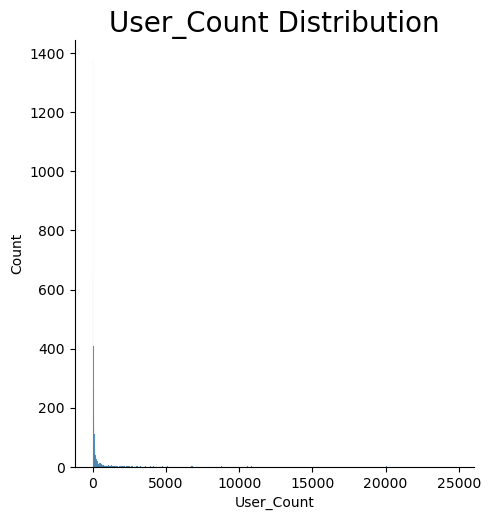

In [47]:
numeric_features = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score'
                   , 'Critic_Count' , 'User_Score' , 'User_Count']
for feature in numeric_features:
    plt.figure(figsize=(18, 10), facecolor='w')
    sns.displot(df[feature])
    plt.title('{} Distribution'.format(feature), fontsize=20)
    plt.show()

Looking at these graphs we can conclude 
- Years of Release , Critic Score and user score have a right skewness distribution 
- NA Sales, EU Sales, JP Sales, Other Sales and User Count have a very dispersed distribution 
- Critic Count has a left skewness distribution 

### Categorial Data

<Figure size 1800x1000 with 0 Axes>

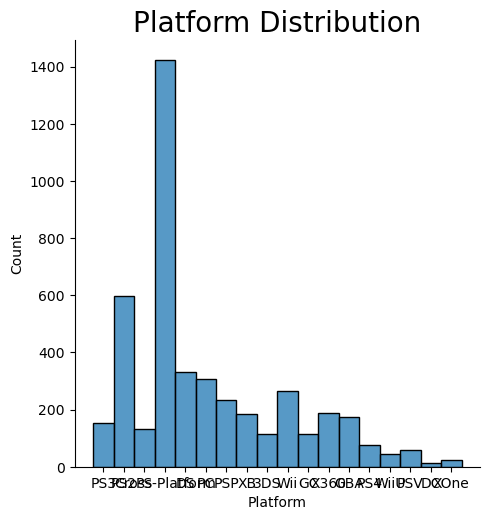

<Figure size 1800x1000 with 0 Axes>

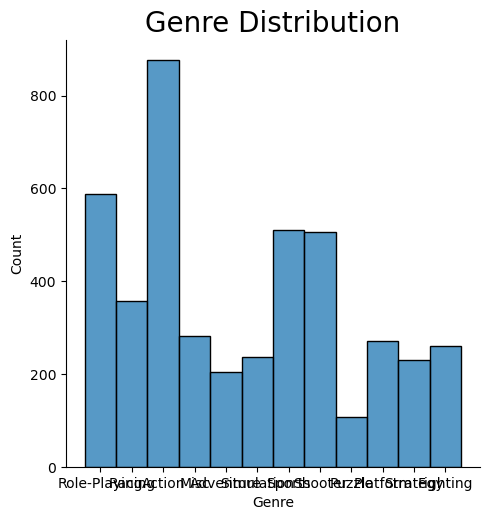

<Figure size 1800x1000 with 0 Axes>

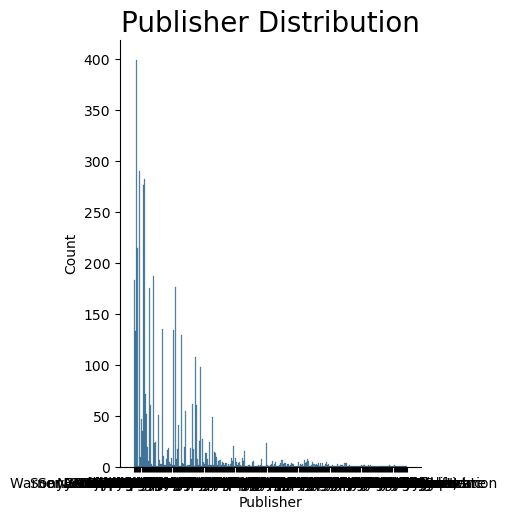

<Figure size 1800x1000 with 0 Axes>

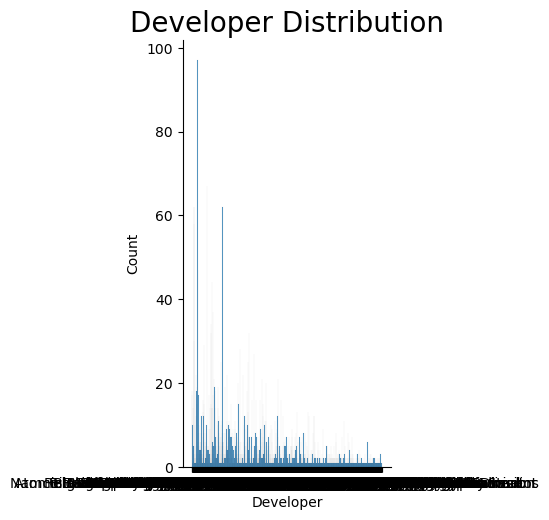

<Figure size 1800x1000 with 0 Axes>

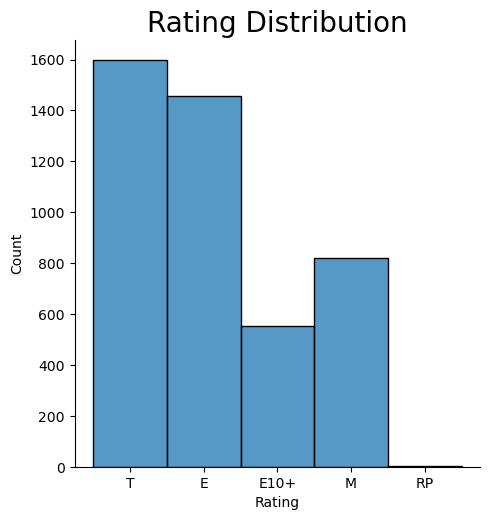

In [50]:
categorical_columns = ["Platform", "Genre", "Publisher", "Developer", "Rating"]
for feature in categorical_columns:
    plt.figure(figsize=(18, 10), facecolor='w')
    sns.displot(df[feature])
    plt.title('{} Distribution'.format(feature), fontsize=20)
    plt.show()

From looking at these graphs we can conclude 
- Platform , Genre, and Rating have a uneven distribution 
- Publisher and Developer have a disparsed distribution 

## Bivariate Analysis

### Comparing Platforms to their average Global Sales

In [ ]:
# Step 1: Group by the original 'Platform' column and calculate averages
platform_averages = df.groupby("Platform")["Global_Sales"].mean().sort_values(ascending=False)

# Step 2: Plot the bar chart for average global sales
plt.figure(figsize=(12, 6))
platform_averages.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Global Sales by Platform", fontsize=16)
plt.xlabel("Platform", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


From looking at the graph, it seems the Play Station (PS) contributed the most to the global sales in the data with around 1.3 Million

### Comparing Publishers to average Global Sales

In [ ]:
# Step 1: Group by 'Publisher_freq' and calculate average global sales
publisher_avg_sales = (
    df.groupby("Publisher")["Global_Sales"].mean().sort_values(ascending=False)
)

# Step 2: Plot the bar chart for publisher frequencies
plt.figure(figsize=(14, 7))
publisher_avg_sales.head(20).plot(
    kind="bar", color="skyblue", edgecolor="black"
)  # Limit to top 20 for readability
plt.title("Average Global Sales by Publisher Frequency", fontsize=16)
plt.xlabel("Publisher Frequency", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Adjust figure size and rotate x-axis labels for readability
plt.figure(figsize=(14, 7))
df.groupby("Developer")["Global_Sales"].mean().sort_values(ascending=False).head(
    20
).plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Average Global Sales by Developer", fontsize=16)
plt.xlabel("Developer", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate labels and align them
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

- Looking at the top 20 publishers in the dataset, GT Interactive and Squaresoft contritubute the most to global sales
- Looking at the top 20 developers in the dataset, Good Science Studio has the highest average global sales and contributes the most to the dataset

### Comparing User Score vs Global Sales & Critic Score vs Global Sales

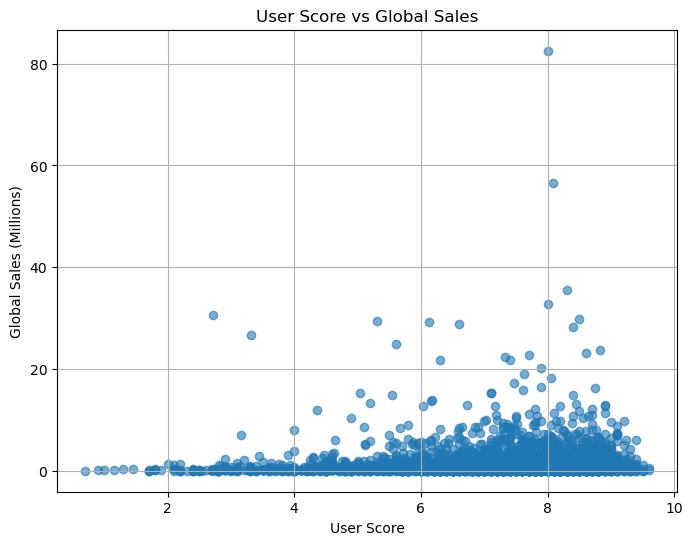

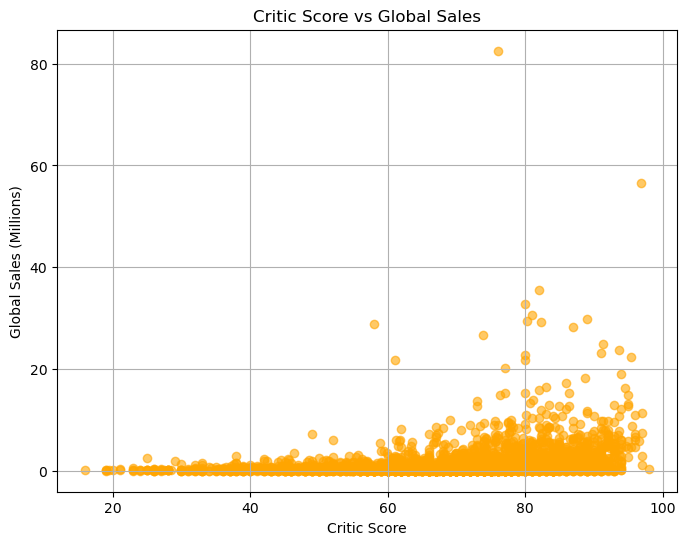

In [64]:
# Scatter plot for User_Score vs Global_Sales
plt.figure(figsize=(8, 6))
plt.scatter(df["User_Score"], df["Global_Sales"], alpha=0.6)
plt.title("User Score vs Global Sales")
plt.xlabel("User Score")
plt.ylabel("Global Sales (Millions)")
plt.grid()
plt.show()

# Scatter plot for Critic_Score vs Global_Sales
plt.figure(figsize=(8, 6))
plt.scatter(df["Critic_Score"], df["Global_Sales"], alpha=0.6, color="orange")
plt.title("Critic Score vs Global Sales")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (Millions)")
plt.grid()
plt.show()

By looking at User Score vs Global Sales graphs we can conclude 
- Most of the data points are concentrated at lower global sales, regardless of user score. This suggests that the majority of products (likely games, based on the axes) achieve relatively modest sales figures
- There are a few outliers with extremely high global sales (above 40 million). These likely represent exceptionally successful products with high popularity which would make them outliers
- Sales do not strongly increase with User Score beyond a certain point. Products with user scores around 7–10 tend to have the highest sales outliers, but many others with similar scores have very low sales
- There is a dense cluster of products with moderate User Scores (5–8) and low sales (below 10 million). This indicates that many products perform adequately. Products with low User Scores (below 4) generally have lower sales

By looking at Critic Score vs Global Sales graphs we can conclude 
- There is a general trend where higher Critic Scores are associated with higher global sales. Products with Critic Scores above 70 are more 
likely to have high sales
- A few outliers with very high global sales (above 40 million) stand out. Most of these outliers also have Critic Scores above 80
- Products with low Critic Scores (below 40) generally have low global sales
- There is a high density of products with Critic Scores between 60 and 80 and sales below 10 million, suggesting that many products perform moderately well
- Products with Critic Scores above 80 seem to have better chances of achieving significant sales. There are still many with moderate sales in this range


Critic Score and User Score have a overall very similiar distribution with some outliars. Since users and critics overall agree on what games are generally good, it will be helpful to predict which ones will sell well as generally good games tend to sell more

## Multivariate Analysis

### User Score and Critic Score vs Global Sales

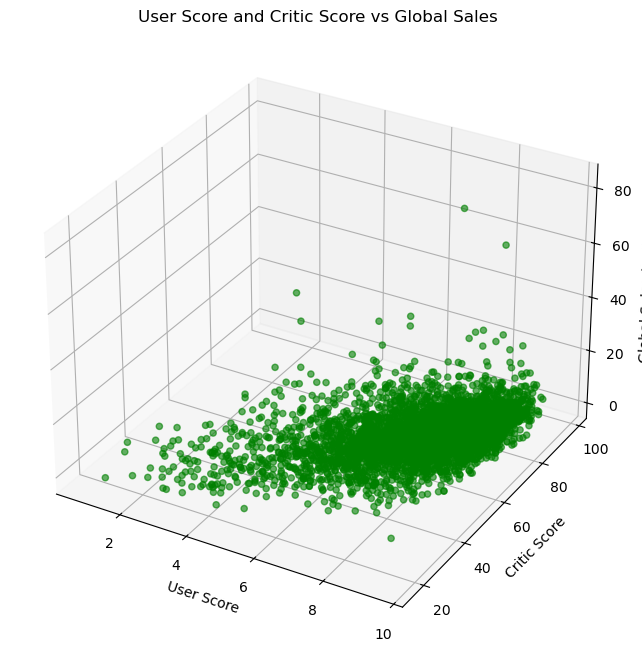

              User_Score  Critic_Score  Global_Sales
User_Score      1.000000      0.630118      0.054913
Critic_Score    0.630118      1.000000      0.252343
Global_Sales    0.054913      0.252343      1.000000


In [66]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 3D Scatter Plot
ax.scatter(
    df["User_Score"], df["Critic_Score"], df["Global_Sales"], c="green", alpha=0.6
)
ax.set_title("User Score and Critic Score vs Global Sales")
ax.set_xlabel("User Score")
ax.set_ylabel("Critic Score")
ax.set_zlabel("Global Sales (Millions)")
plt.show()

# Correlation matrix
correlation = df[["User_Score", "Critic_Score", "Global_Sales"]].corr()

print(correlation)

By looking at these graphs we can conclude 
- In general higher user score also coincides with higher critic score which results in global sales to increase for higher
scores
-  A large cluster of data points exists where both User Scores and Critic Scores are in the mid-to-high range (approximately 6–10 for User Score and 50–80 for Critic Score). This suggests many products with moderate to high sales tend to receive positive scores from both users and critics
-  There are a few data points with very high Global Sales that are separated from the dense cluster. These are likely representing successful products, possibly independent of user or critic scores which would make them outliers
-  Data points are spread across a wide range of User and Critic Scores, but higher sales seem more frequent at higher scores

## Feature Selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold on the correct DataFrame
threshold = 0.01
selector = VarianceThreshold(threshold)
selected_features = selector.fit_transform(numerical_data)

# Get the columns that passed the variance threshold
selected_columns = numerical_data.columns[selector.get_support()]
df_feature_selected = numerical_data[selected_columns]

# Display selected features
print("Selected Features after Variance Thresholding:")
print(selected_columns)

correlation_matrix = numerical_data.corr()

# Find features highly correlated with Global_Sales (threshold > 0.85)
highly_correlated_with_global = correlation_matrix["Global_Sales"][
    correlation_matrix["Global_Sales"] > 0.85
].index.tolist()

print("highly_correlated_with_global:", highly_correlated_with_global)

# Remove Global_Sales from this list (we keep it as the target)
highly_correlated_with_global.remove("Global_Sales")

# Drop these features from selected_columns
selected_columns = [
    col for col in selected_columns if col not in highly_correlated_with_global
]

print("Final Selected Features after Correlation-Based Filtering:")
print(selected_columns)


df_feature_selected = numerical_data[selected_columns]

Here we are filtering our data to include the features we believe our model will have the best accuracy with

## Feature Scaling

In [ ]:
from sklearn.model_selection import train_test_split

# x = df_feature_selected.drop(["Global_Sales"], axis=1)
# y = df_feature_selected["Global_Sales"]

train_x, test_x, train_y, test_y = train_test_split(
    df_feature_selected.drop(["Global_Sales"], axis=1),
    df_feature_selected["Global_Sales"],
    test_size=0.2,
    random_state=1,
)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

Here we use feature scaling our features in order to normalize the range of features in the data set 

# Modeling 

In [ ]:
# Create a binary target variable based on Global_Sales
median_sales = df["Global_Sales"].median()
df["High_Sales"] = (df["Global_Sales"] > median_sales).astype(int)

# Drop the original Global_Sales column
df.drop("Global_Sales", axis=1, inplace=True)

# Define features (X) and target (y)
X = df.drop(["High_Sales", "Name", "Publisher", "Developer"], axis=1, errors="ignore")
y = df["High_Sales"]

# Split the dataset into training and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale numerical features
numeric_cols = train_x.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
train_x[numeric_cols] = scaler.fit_transform(train_x[numeric_cols])
test_x[numeric_cols] = scaler.transform(test_x[numeric_cols])

Here we are creating two different data sets in order to train with our features engineering process and one without feature 
engineering in order to see how our results will vary

## Logistic Regression 

In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state=1, max_iter=1000)
lr.fit(train_x, train_y)
lr_predict = lr.predict(test_x)
lr_conf_matrix = confusion_matrix(test_y, lr_predict)
lr_acc_score = accuracy_score(test_y, lr_predict)
print("=== Logistic Regression ===")
print("Confusion Matrix:")
print(lr_conf_matrix)
print("Accuracy:", lr_acc_score * 100)
print(classification_report(test_y, lr_predict))

## K-Nearest Neighbors 

In [ ]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
knn_predict = knn.predict(test_x)
knn_conf_matrix = confusion_matrix(test_y, knn_predict)
knn_acc_score = accuracy_score(test_y, knn_predict)
print("\n=== K-Nearest Neighbors ===")
print("Confusion Matrix:")
print(knn_conf_matrix)
print("Accuracy:", knn_acc_score * 100)
print(classification_report(test_y, knn_predict))

## Random Forest 

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=12)
rf.fit(train_x, train_y)
rf_predicted = rf.predict(test_x)
rf_conf_matrix = confusion_matrix(test_y, rf_predicted)
rf_acc_score = accuracy_score(test_y, rf_predicted)
print("\n=== Random Forest ===")
print("Confusion Matrix:")
print(rf_conf_matrix)
print("Accuracy:", rf_acc_score * 100)
print(classification_report(test_y, rf_predicted))

## Decision Tree 

In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=30)
dt.fit(train_x, train_y)
dt_predicted = dt.predict(test_x)
dt_conf_matrix = confusion_matrix(test_y, dt_predicted)
dt_acc_score = accuracy_score(test_y, dt_predicted)
print("\n=== Decision Tree ===")
print("Confusion Matrix:")
print(dt_conf_matrix)
print("Accuracy:", dt_acc_score * 100)
print(classification_report(test_y, dt_predicted))

## Gradient Boosting 

In [ ]:
# Gradient Boosting
gvc = GradientBoostingClassifier(random_state=0)
gvc.fit(train_x, train_y)
gvc_predicted = gvc.predict(test_x)
gvc_conf_matrix = confusion_matrix(test_y, gvc_predicted)
gvc_acc_score = accuracy_score(test_y, gvc_predicted)
print("\n=== Gradient Boosting ===")
print("Confusion Matrix:")
print(gvc_conf_matrix)
print("Accuracy:", gvc_acc_score * 100)
print(classification_report(test_y, gvc_predicted))

## Model Tuning 